In [1]:
import pandas as pd
import numpy as np
import osmnx as ox
import datetime
import seaborn as sns

In [4]:
filename = "/home/peyman/Documents/projects/balad/codes/temp/part-00002-498c167d-fb29-4098-a9f9-682631b98b93-c000.snappy"
# filename = "balad/part1/part-00002-498c167d-fb29-4098-a9f9-682631b98b93-c000.snappy.parquet"

In [5]:
data = pd.read_parquet(filename)

In [13]:
for i in range(1000):
    print(data.iloc[i]['location'])

0101000000A6B915C26AAC4940CAFD0E4581DE4140
010100000032AA0CE36EAC49402502D53F88DE4140
010100000071AC8BDB68AC494050E09D7C7ADE4140
01010000004DD6A88768AC49407C0F971C77DE4140
0101000000399B8E006EAC4940B5C2F4BD86DE4140
0101000000FF21FDF675AC49407B15191D90DE4140
0101000000FF21FDF675AC49407B15191D90DE4140
0101000000FF21FDF675AC49407B15191D90DE4140
0101000000FF21FDF675AC49407B15191D90DE4140
0101000000FF21FDF675AC49407B15191D90DE4140
01010000001FA2D11DC4AC494018B14F00C5DE4140
0101000000C24CDBBFB2AC494031410DDFC2DE4140
01010000008FFF024180AC49405FB532E197DE4140
01010000009BE7887C97AC4940FDF9B660A9DE4140
010100000049F59D5F94AC49405D6A847EA6DE4140
01010000004AEF1B5F7BAC4940D881734694DE4140
0101000000596DFE5F75AC494004E5B67D8FDE4140
010100000082A8FB00A4AC4940B4024356B7DE4140
0101000000323B8BDEA9AC4940B7EF517FBDDE4140
0101000000BF49D3A068AC494081CCCEA277DE4140
0101000000D0EE906280AC4940A0A4C00298DE4140
0101000000C6C4E6E3DAAC4940D7C1C1DEC4DE4140
010100000086032159C0AC4940664E97C5C4DE4140
01010000007

In [13]:
data.iloc[:50]['way_id']

0     100958959
1     100958959
2     100958959
3     100958959
4     100958959
5     100958959
6     100958959
7     100958959
8     100958959
9     100958959
10    100958959
11    100958959
12    100958959
13    100958959
14    100958959
15    100958959
16    100958959
17    100958959
18    100958959
19    100958959
20    100958959
21    100958959
22    100958959
23    100958959
24    100958959
25    100958959
26    100958959
27    100958959
28    100958959
29    100958959
30    144327000
31    144327000
32    144327000
33    144327000
34    144327000
35    144327000
36    144327000
37    144327000
38    144327000
39    144327000
40    144327000
41    144327000
42    144327000
43    144327000
44    144327000
45    144327000
46    144327000
47    144327000
48    144327000
49    144327000
Name: way_id, dtype: int32

In [64]:
data.iloc[:10]['route_slug']

0    MfE6rZrZKr
1    MfE6rZrZKr
2    MfE6rZrZKr
3    MfE6rZrZKr
4    MfE6rZrZKr
5    Cl9qelgbwW
6    Cl9qelgbwW
7    Cl9qelgbwW
8    Cl9qelgbwW
9    Cl9qelgbwW
Name: route_slug, dtype: object

In [15]:
data.iloc[:10]['location']

0    0101000000A6B915C26AAC4940CAFD0E4581DE4140
1    010100000032AA0CE36EAC49402502D53F88DE4140
2    010100000071AC8BDB68AC494050E09D7C7ADE4140
3    01010000004DD6A88768AC49407C0F971C77DE4140
4    0101000000399B8E006EAC4940B5C2F4BD86DE4140
5    0101000000FF21FDF675AC49407B15191D90DE4140
6    0101000000FF21FDF675AC49407B15191D90DE4140
7    0101000000FF21FDF675AC49407B15191D90DE4140
8    0101000000FF21FDF675AC49407B15191D90DE4140
9    0101000000FF21FDF675AC49407B15191D90DE4140
Name: location, dtype: object

In [14]:
total_samples = []
limit = 15
current_data = datetime.datetime.fromtimestamp(int(data.iloc[0]['timestamp'])/1000)
for i in range(100):
# for i in range(200):
    if data.iloc[i]['route_slug'] != data.iloc[i + 1]['route_slug']:
        current_data = datetime.datetime.fromtimestamp(int(data.iloc[i+1]['timestamp'])/1000)
        continue
    next_data = datetime.datetime.fromtimestamp(int(data.iloc[i+1]['timestamp'])/1000)
    diff = (next_data-current_data).total_seconds()
    current_data = next_data
    print(diff)

2.019
-4.033
-1.029
4.567
47.097
-20.253
18.743
-46.59
-4.051
-16.296
7.122
-1.004
-2.107
14.648
2.008
-23.827
31.216
-6.436
-16.665
0.526
-0.385
1.876
-0.477
-3.038
-2.153
-2.535
3.193
-1.674
4.526
-1.51
-6.036
3.517
1.483
-0.476
-3.542
3.019
8.611
-3.537
2.007
-0.532
8.611
-1.121
4.281
-1.026
-12.122
-1.997
-2.043
3.557
18.056
-34.94
14.352
15.021
-2.999
1.515
11.031
-3.988
8.578
17.653
-20.671
8.565
-14.033
-5.57
21.093
-14.909
19.402
-26.964
16.999
-0.8
-0.5
6.068
19.183
-14.649
12.959
-20.096
21.574
-19.197
-12.972
12.438
-1.61
-15.112


In [6]:
total_samples = []
limit = 15
current_data = datetime.datetime.fromtimestamp(int(data.iloc[0]['timestamp'])/1000)
for i in range(len(data)-1):
# for i in range(200):
    if data.iloc[i]['route_slug'] != data.iloc[i + 1]['route_slug']:
        current_data = datetime.datetime.fromtimestamp(int(data.iloc[i+1]['timestamp'])/1000)
        continue
    next_data = datetime.datetime.fromtimestamp(int(data.iloc[i+1]['timestamp'])/1000)
    diff = (next_data-current_data).total_seconds()
    current_data = next_data
    if abs(diff) > limit:
        total_samples.append((i, diff))

In [71]:
a = datetime.datetime.fromtimestamp(int(data.iloc[5]['timestamp'])/1000)
b = datetime.datetime.fromtimestamp(int(data.iloc[6]['timestamp'])/1000)
diff = (b-a).total_seconds()

In [7]:
values = [total_samples[i][1] for i in range(len(total_samples))]

/home/peyman/anaconda3/envs/conda_env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

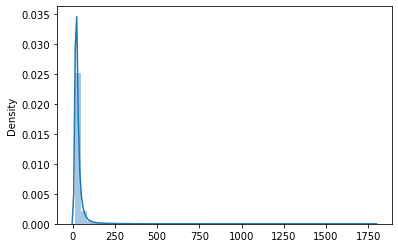

In [8]:
sns.distplot(values)

In [10]:
len(data)/len(values)

32.37916341595151

In [96]:
longitudes = []
latitudes = []
i = 0
while data.iloc[i]['way_id'] == data.iloc[i+1]['way_id']:
    point = wkb.loads(data.iloc[i]['location'], hex=True)
    longitudes.append(point.x)
    latitudes.append(point.y)
    i += 1

In [11]:
from shapely import wkb

In [81]:
hexlocation = "0101000000A6B915C26AAC4940CAFD0E4581DE4140"
point = wkb.loads(hexlocation, hex=True)
longitude1 = point.x
latitude1 = point.y
print(latitude1, longitude1)

35.73832 51.347008


/home/peyman/anaconda3/envs/conda_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
hexlocation = "010100000032AA0CE36EAC49402502D53F88DE4140"
point = wkb.loads(hexlocation, hex=True)
longitude2 = point.x
latitude2 = point.y
print(latitude2, longitude2)

35.738533 51.347134


In [5]:
north = 35.7417
south = 35.7340
east = 51.3520
west = 51.3430
graph = ox.graph_from_bbox(north, south, east, west, network_type='drive')

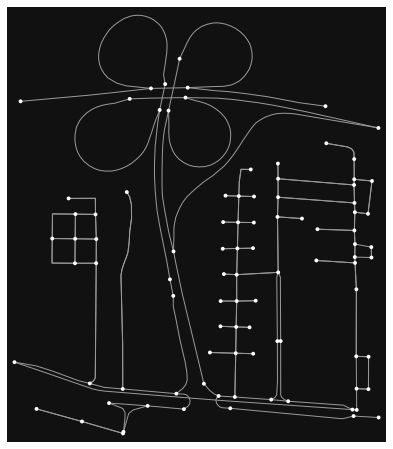

In [71]:
fig, ax = ox.plot_graph(graph)

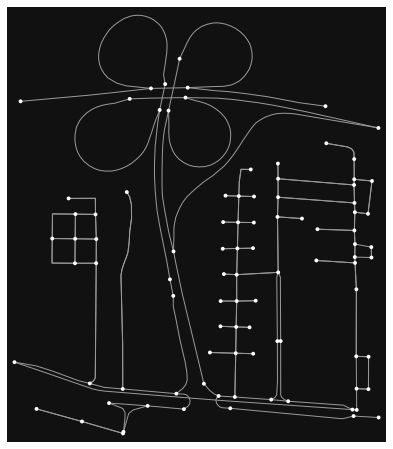

In [65]:
fig, ax = ox.plot_graph(graph)

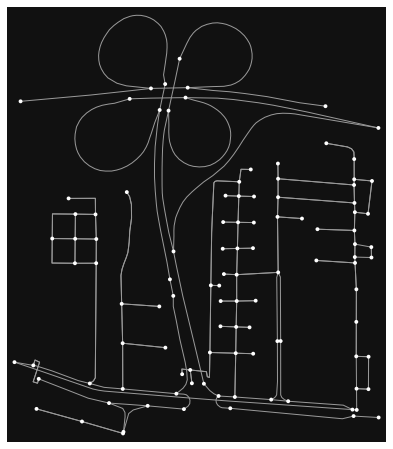

In [63]:
fig, ax = ox.plot_graph(graph)

In [7]:
area = ox.geometries_from_bbox(north, south, east, west, tags={'highway':True})

/home/peyman/anaconda3/envs/conda_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
list(area.iloc[10]['geometry'].coords)

[(51.3472194, 35.7407198),
 (51.3480011, 35.7407096),
 (51.348407, 35.740681),
 (51.3490087, 35.7406171),
 (51.3493678, 35.7405693),
 (51.3498089, 35.740499),
 (51.3502399, 35.7404272),
 (51.3519522, 35.7401158),
 (51.3535498, 35.7398617),
 (51.3564339, 35.7393934),
 (51.3573993, 35.7392312),
 (51.3580074, 35.7391372),
 (51.3587991, 35.7390121),
 (51.3598111, 35.7388753),
 (51.361123, 35.7387551),
 (51.3617123, 35.7387196),
 (51.3622706, 35.7387007),
 (51.3629363, 35.7387078),
 (51.3635887, 35.7387411),
 (51.3639677, 35.7387629),
 (51.3643467, 35.7388021),
 (51.3651181, 35.7388848),
 (51.3656292, 35.7389586)]

In [42]:
area.iloc[10]['geometry'].coords

/home/peyman/anaconda3/envs/conda_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
area[:20]

,unique_id,osmid,element_type,highway,geometry,bench,bus,name,name:en,public_transport,...,destination,lanes,bridge,bridge:name,layer,full_name:fa,abutters,service,old_name,footway
0,node/26366111,26366111,node,motorway_junction,POINT (51.34707 35.74149),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/26367673,26367673,node,motorway_junction,POINT (51.34637 35.74090),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/26367675,26367675,node,motorway_junction,POINT (51.34722 35.74072),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/26527608,26527608,node,motorway_junction,POINT (51.35065 35.74055),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/26527616,26527616,node,motorway_junction,POINT (51.34692 35.73766),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node/26527621,26527621,node,motorway_junction,POINT (51.34659 35.74047),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,node/3819203991,3819203991,node,bus_stop,POINT (51.35188 35.73450),yes,yes,مسجد,Mosque,platform,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,node/3823903594,3823903594,node,bus_stop,POINT (51.35184 35.73429),yes,yes,مسجد,Mosque,platform,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,node/3828324128,3828324128,node,bus_stop,POINT (51.34784 35.73465),yes,yes,مرزداران,Marzdaran,platform,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,node/3834926374,3834926374,node,bus_stop,POINT (51.34758 35.73468),yes,yes,پل مرزداران,Marzdaran,platform,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
import osmnx as ox
import matplotlib.pyplot as plt
%matplotlib inline

# Specify the name that is used to seach for the data
place_name = "Kamppi, Helsinki, Finland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)

/home/peyman/anaconda3/envs/conda_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 6000x4000 with 0 Axes>

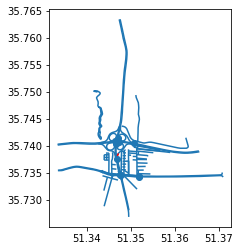

In [87]:
area.plot()
plt.plot([51.34, 51.35], [35.735, 35.740])

In [77]:
import matplotlib.pyplot as plt

/home/peyman/anaconda3/envs/conda_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/peyman/anaconda3/envs/conda_env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 6000x4000 with 0 Axes>

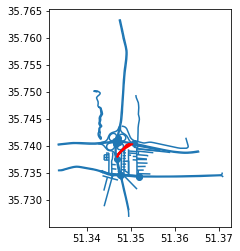

In [98]:
plt.figure(dpi=1000)
area.plot()
plt.plot(longitudes, latitudes, c='red')

In [22]:
import numpy as np

In [25]:
a = np.random.rand(5, 5, 3)

In [29]:
a[:]

array([[[0.25889679, 0.95553253, 0.65657105],
        [0.6262336 , 0.19900728, 0.51978685],
        [0.93286669, 0.50127978, 0.65219215],
        [0.90686401, 0.23600347, 0.19770301],
        [0.79005855, 0.08387084, 0.7017986 ]],

       [[0.5438975 , 0.16738987, 0.01335348],
        [0.46414146, 0.31455691, 0.56986493],
        [0.6173354 , 0.22153409, 0.77738367],
        [0.09172689, 0.02201675, 0.64670169],
        [0.92112161, 0.91050044, 0.37466076]],

       [[0.94061205, 0.28288159, 0.27633455],
        [0.6479264 , 0.01122872, 0.13757293],
        [0.81563824, 0.54331965, 0.61996238],
        [0.31980918, 0.36747391, 0.5793221 ],
        [0.32205784, 0.21978244, 0.03153674]],

       [[0.73140103, 0.1744135 , 0.1397479 ],
        [0.70971412, 0.27841547, 0.74118523],
        [0.20523788, 0.10268445, 0.38485177],
        [0.36245768, 0.45580082, 0.90110093],
        [0.97576917, 0.43913049, 0.60129279]],

       [[0.66654607, 0.56658913, 0.56469618],
        [0.17522329, 0.977

In [34]:
a[:][0]

array([[0.25889679, 0.95553253, 0.65657105],
       [0.6262336 , 0.19900728, 0.51978685],
       [0.93286669, 0.50127978, 0.65219215],
       [0.90686401, 0.23600347, 0.19770301],
       [0.79005855, 0.08387084, 0.7017986 ]])

In [41]:
a[:, :, 0][0]

array([0.25889679, 0.6262336 , 0.93286669, 0.90686401, 0.79005855])

In [36]:
b = np.random.rand(5, 5)

In [37]:
b

array([[0.93963916, 0.40206628, 0.77660649, 0.36314981, 0.76918673],
       [0.3367739 , 0.78550138, 0.34055864, 0.25008999, 0.18395065],
       [0.645311  , 0.85592866, 0.65230103, 0.0185837 , 0.37182855],
       [0.78614036, 0.40748084, 0.10644227, 0.61698421, 0.17862519],
       [0.70844915, 0.33591786, 0.38805794, 0.89222577, 0.51311388]])

In [38]:
b[:, 0]

array([0.93963916, 0.3367739 , 0.645311  , 0.78614036, 0.70844915])

In [53]:
b = [[[1, 1], [2, 2], [3, 3]], [[1, 1], [2, 2], [3, 3]], [[1, 1], [2, 2], [3, 3]], [[1, 1], [2, 2], [3, 3]], [[1, 1], [2, 2], [3, 3]]]

In [49]:
[b[i][j][0] for i in range(len(b)) for j in range(len(b[i]))]

[1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]

In [52]:
[b[0][i][0] for i in range(len(b[0]))]

[1, 3, 3]